# Photonic Quantum Convolutional Neural Network with Adaptive State Injection

In this notebook, we will implement the Photonic QCNN from [this paper](https://arxiv.org/abs/2504.20989) and display its usage on the binary 8x8 MNIST classification task of differentiating 0 and 1. All of this will be done using [MerLin](https://merlinquantum.ai), a photonic QML framework for the optimization of photonic circuits that was integrated with PyTorch for intuitive usage.

# 0. Imports

In [1]:
import io
import math
import re
import sys
from collections.abc import Generator
from typing import Union

import matplotlib.pyplot as plt
import merlin
import numpy as np
import sympy as sp
import torch
import torch.nn.functional as F  # noqa: N812
from merlin import CircuitConverter
from merlin import build_slos_distribution_computegraph as build_slos_graph
from perceval import Circuit, GenericInterferometer, catalog
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import Tensor, nn, optim
from tqdm import trange

# 1. Data

Function to fetch the 8x8 MNIST dataset from sklearn and choose the selected labels.

In [2]:
def get_mnist(random_state, class_list=(0, 1)):
    """
    Get MNIST dataset reduced to certain labels.

    :param random_state
    :param class_list: List of labels to keep

    :return: x_train, x_test, y_train, y_test
    """
    mnist_x, mnist_y = load_digits(return_X_y=True)

    # Keep only selected classes
    mask = np.isin(mnist_y, class_list)
    mnist_x = mnist_x[mask]
    mnist_y = mnist_y[mask]

    # Train/test split
    mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test = train_test_split(
        mnist_x, mnist_y, test_size=200, random_state=random_state
    )
    # Since there are only 360 data points in this specific dataset with labels = 0 or 1, that implies that we will have 160 training points.

    # Reshape to 8×8 images
    mnist_x_train = mnist_x_train.reshape(-1, 8, 8)
    mnist_x_test = mnist_x_test.reshape(-1, 8, 8)

    return mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test


# Visualize an image from our training data
x_train, x_test, y_train, y_test = get_mnist(42)
plt.imshow(x_train[0], cmap="gray")
plt.axis("off")  # hide axes
plt.show()
print(f"With label: {y_train[0]}")

To convert the dataset arrays to data loaders.

In [3]:
def convert_dataset_to_tensor(x_train, x_test, y_train, y_test):
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    return x_train, x_test, y_train, y_test


def convert_tensor_to_loader(x_train, y_train, batch_size=6):
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    return train_loader

# 2. Model

We will start by defining 1 layer at a time. Let us start with the OneHotEncoder class which encodes each image to our circuit using amplitude encoding.

In [4]:
class OneHotEncoder(nn.Module):
    def __init__(self):
        """
        One Hot Encoder

        Converts an image X to density matrix in the One Hot Amplitude
        basis. For a given d x d image, the density matrix will be of
        size d^2 x d^2.
        """
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        if x.dim() == 3:
            x = x.unsqueeze(1)

        norm = torch.sqrt(torch.square(torch.abs(x)).sum(dim=(1, 2, 3)))
        x = x / norm.view(-1, 1, 1, 1)

        # Flatten each image and multiply by transpose to get density matrix
        x_flat = x.reshape(x.shape[0], -1)
        rho = x_flat.unsqueeze(2) @ x_flat.unsqueeze(1)
        rho = rho.to(torch.complex64)

        return rho

    def __repr__(self):
        return "OneHotEncoder()"

Second, we will define the convolutional layer called QConv2d and its parent abstract class AParametrizedLayer.

In [5]:
class AParametrizedLayer(nn.Module):
    """
    Abstract parametrized layer.

    Base class layer for inheriting functionality methods.

    Args:
        dims (tuple): Input dimensions into a parametrized layer.
    """

    def __init__(self, dims: tuple[int]):
        super().__init__()
        self.dims = dims
        self._training_params = []

        if dims[0] != dims[1]:
            raise NotImplementedError("Non-square images not supported yet.")

    def _set_param_names(self, circuit):
        """
        Ensures that two different parametrized circuits have different
        perceval parameter names.
        """
        param_list = list(circuit.get_parameters())

        if not self._training_params:
            param_start_idx = 0
        else:
            # Take index from last parameter name
            param_start_idx = int(
                re.search(r"\d+", self._training_params[-1].name).group()
            )

        for i, p in enumerate(param_list):
            p.name = f"phi{i + param_start_idx + 1}"

        for _, comp in circuit:
            if hasattr(comp, "_phi"):
                param = comp.get_parameters()[0]
                param._symbol = sp.S(param.name)

        self._training_params.extend(param_list)

    def _modify_channels(self, rho, u, uc):
        """
        Prepares shapes for rho, main register U, channel unitary U
        """
        b = rho.shape[0]
        c_out = self.out_channels
        c_in = self.in_channels

        # Evaluate unitary on channels register
        if c_out is not None:
            uc = self._circuit_graph_c.to_tensor(self.phi[-self._n_params_c :])

        # No channel register
        if c_in is None and c_out is None:
            pass

        # Channel register but apply no operations to channels
        elif c_in is not None and c_out is None:
            i = torch.eye(c_in)  # noqa: E741
            u = torch.kron(i, u)

        # Create channel register
        elif c_in is None and c_out is not None:
            i_rho = torch.zeros((c_out, c_out))
            i_rho[0][0] = 1.0
            i_rho = i_rho.expand(b, -1, -1)

            rho = torch.vmap(torch.kron)(i_rho, rho)

        # Expand the size of the channel register.
        elif c_out > c_in:
            rho = self._mode_insertion(rho)

        # Apply channels to unchanged size register
        elif c_out == c_in:
            pass

        # Apply channels unitary to subset of channels - Transpose convolutions only.
        elif c_out < c_in:
            if c_in - c_out == 1:
                uc = nn.functional.pad(uc, (0, 1, 0, 1))
                uc[c_out][c_out] = 1.0
            else:
                uc = torch.kron(uc, torch.eye(c_in - c_out))
        else:
            raise NotImplementedError("I might have forgotten something.")

        return rho, u, uc


class QConv2d(AParametrizedLayer):
    def __init__(
        self,
        dims,
        kernel_size: int,
        stride: int = None,
        in_channels: int = None,
        out_channels: int = None,
    ):
        """
        Quantum 2D Convolutional layer to processor

        Args:
            dims: Input dimensions.
            kernel_size: Size of universal interferometer
            stride: Stride of the universal interferometer across the
                modes.
        """
        if in_channels is not None and out_channels is None:
            raise ValueError("Please specify a number of output channels")

        super().__init__(dims)
        self.kernel_size = kernel_size
        self.stride = kernel_size if stride is None else stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Define filters
        filters = []
        for _ in range(2):
            filter = GenericInterferometer(
                kernel_size, catalog["mzi phase first"].generate
            )
            self._set_param_names(filter)
            filters.append(filter)

        # Create x and y and channel registers
        self._reg_x = Circuit(dims[0], name="Conv X")
        self._reg_y = Circuit(dims[1], name="Conv Y")

        # Add filters with specified stride
        for i in range((dims[0] - kernel_size) // self.stride + 1):
            self._reg_x.add(self.stride * i, filters[0])

        for i in range((dims[1] - kernel_size) // self.stride + 1):
            self._reg_y.add(self.stride * i, filters[1])

        self._n_params_x = len(self._reg_x.get_parameters())
        self._n_params_y = len(self._reg_y.get_parameters())
        num_params = self._n_params_x + self._n_params_y

        if out_channels is not None:
            self._reg_c = GenericInterferometer(
                out_channels, catalog["mzi phase first"].generate
            )
            self._set_param_names(self._reg_c)
            self._n_params_c = len(self._reg_c.get_parameters())
            num_params += self._n_params_c

        # Suppress unnecessary print statements from pcvl_pytorch
        original_stdout = sys.stdout
        sys.stdout = io.StringIO()
        try:
            # Build circuit graphs for the two registers separately.
            self._circuit_graph_x = CircuitConverter(
                self._reg_x, ["phi"], torch.float32
            )
            self._circuit_graph_y = CircuitConverter(
                self._reg_y, ["phi"], torch.float32
            )
            if out_channels is not None:
                self._circuit_graph_c = CircuitConverter(
                    self._reg_c, ["phi"], torch.float32
                )
        finally:
            sys.stdout = original_stdout

    def forward(self, rho, adjoint=False):
        b = len(rho)

        phi_x = self.phi[: self._n_params_x]
        phi_y = self.phi[self._n_params_x : self._n_params_x + self._n_params_y]

        ux = self._circuit_graph_x.to_tensor(phi_x)
        uy = self._circuit_graph_y.to_tensor(phi_y)
        u = torch.kron(ux, uy)

        # Evaluate unitary on channels register
        if self.out_channels is not None:
            uc = self._circuit_graph_c.to_tensor(self.phi[-self._n_params_c :])
        else:
            uc = None

        rho, u, uc = self._modify_channels(rho, u, uc)

        if self.out_channels is not None:
            u = torch.kron(uc, u)

        u = u.unsqueeze(0).expand(b, -1, -1)
        udag = u.transpose(1, 2).conj()

        # There is only one photon in each register, can apply the U directly.
        if not adjoint:
            u_rho = torch.bmm(u, rho)
            new_rho = torch.bmm(u_rho, udag)
        else:
            # Apply adjoint to rho
            udag_rho = torch.bmm(udag, rho)
            new_rho = torch.bmm(udag_rho, u)

        return new_rho

    def __repr__(self):
        c_in = 0 if self.in_channels is None else self.in_channels
        c_out = 0 if self.out_channels is None else self.out_channels
        return f"QConv2d({self.dims}, kernel_size={self.kernel_size}, in_channels={c_in}, out_channels={c_out})"

Third, there is the pooling layer: QPooling.

In [6]:
class QPooling(torch.nn.Module):
    """
    Quantum pooling layer

    :param dims: Input image dimensions
    :param kernel_size: Dimension by which the image is reduced.
    :param channels: Number of input channels.
    """

    def __init__(self, dims, kernel_size, channels=None):
        d = dims[0]
        k = kernel_size
        c = 1 if channels is None else channels
        new_d = d // kernel_size

        super().__init__()
        self.dims = d
        self._new_d = new_d
        self.kernel_size = k
        self.channels = channels

        # Create all index combinations at once
        x = torch.arange(c * d**2)
        y = torch.arange(c * d**2)

        # Let f, h represent the channel indices.
        # In basis: |e_f>|e_i>|e_j><e_h|<e_l|<e_m|
        f = x // (d**2)
        h = y // (d**2)

        # Let i, j, l, m represent the one hot indices
        i = (x % (d**2)) // d
        j = (x % (d**2)) % d
        l = (y % (d**2)) // d  # noqa: E741
        m = (y % (d**2)) % d

        # Create meshgrids for pairwise operations
        f_grid, h_grid = torch.meshgrid(f, h, indexing="ij")
        i_grid, l_grid = torch.meshgrid(i, l, indexing="ij")
        j_grid, m_grid = torch.meshgrid(j, m, indexing="ij")

        # Ensure that odd mode photon numbers match
        inject_condition = (i_grid % k == l_grid % k) & (j_grid % k == m_grid % k)
        match_odd1 = ((i_grid % k != 0) & (i_grid == l_grid)) | (i_grid % k == 0)
        match_odd2 = ((j_grid % k != 0) & (j_grid == m_grid)) | (j_grid % k == 0)

        mask = inject_condition & match_odd1 & match_odd2
        mask_coords = torch.nonzero(mask, as_tuple=False)
        self._mask_coords = (mask_coords[:, 0], mask_coords[:, 1])

        new_i = i_grid[mask] // k
        new_j = j_grid[mask] // k
        new_l = l_grid[mask] // k
        new_m = m_grid[mask] // k

        self._new_x = new_i * new_d + new_j + f_grid[mask] * new_d**2
        self._new_y = new_l * new_d + new_m + h_grid[mask] * new_d**2

    def forward(self, rho):
        b = len(rho)
        c = 1 if self.channels is None else self.channels

        b_indices = torch.arange(b).unsqueeze(1).expand(-1, len(self._new_x))
        b_indices = b_indices.reshape(-1)

        new_x = self._new_x.expand(b, -1).reshape(-1)
        new_y = self._new_y.expand(b, -1).reshape(-1)

        new_rho = torch.zeros(
            b,
            c * self._new_d**2,
            c * self._new_d**2,
            dtype=rho.dtype,
            device=rho.device,
        )

        values = rho[:, self._mask_coords[0], self._mask_coords[1]].reshape(-1)
        new_rho.index_put_((b_indices, new_x, new_y), values, accumulate=True)

        return new_rho

Fourth, there is the QDense layer which needs the functions generate_all_fock_states and compute_amplitude.

In [7]:
def generate_all_fock_states(m, n) -> Generator:
    """
    Generate all possible Fock states for n photons and m modes.

    Args:
        m: Number of modes
        n: Number of photons

    Returns:
        Generator of tuples of each Fock state.
    """
    if n == 0:
        yield (0,) * m
        return
    if m == 1:
        yield (n,)
        return

    for i in range(n + 1):
        for state in generate_all_fock_states(m - 1, n - i):
            yield (i,) + state


def compute_amplitudes(self, unitary: Tensor, input_state: list[int]) -> torch.Tensor:
    """
    Compute the amplitudes using the pre-built graph.

    Args:
        unitary (torch.Tensor): Single unitary matrix [m x m] or batch
            of unitaries [b x m x m]. The unitary should be provided in
            the complex dtype corresponding to the graph's dtype.
            For example: for torch.float32, use torch.cfloat;
            for torch.float64, use torch.cdouble.
        input_state (list[int]): Input_state of length self.m with
            self.n_photons in the input state

    Returns:
        Tensor: Output amplitudes associated with each Fock state.
    """
    # Add batch dimension
    if len(unitary.shape) == 2:
        unitary = unitary.unsqueeze(0)

    if any(n < 0 for n in input_state) or sum(input_state) == 0:
        raise ValueError("Photon numbers cannot be negative or all zeros")

    if self.no_bunching and not all(x in [0, 1] for x in input_state):
        raise ValueError(
            "Input state must be binary (0s and 1s only) in non-bunching mode"
        )

    batch_size, m, m2 = unitary.shape
    if m != m2 or m != self.m:
        raise ValueError(
            f"Unitary matrix must be square with dimension {self.m}x{self.m}"
        )

    # Check dtype to match the complex dtype used for the graph building
    if unitary.dtype != self.complex_dtype:
        raise ValueError(
            f"Unitary dtype {unitary.dtype} doesn't match the expected complex"
            f" dtype {self.complex_dtype} for the graph built with dtype"
            f" {self.dtype}. Please provide a unitary with the correct dtype "
            f"or rebuild the graph with a compatible dtype."
        )
    idx_n = []
    self.norm_factor_input = 1
    for i, count in enumerate(input_state):
        for c in range(count):
            self.norm_factor_input *= c + 1
            idx_n.append(i)

            bounds1 = self.index_photons[len(idx_n) - 1][1]
            bounds2 = self.index_photons[len(idx_n) - 1][0]
            if (i > bounds1) or (i < bounds2):
                raise ValueError(
                    f"Input state photons must be bounded by {self.index_photons}"
                )

    # Get device from unitary
    device = unitary.device

    # Initial amplitude
    amplitudes = torch.ones((batch_size, 1), dtype=self.complex_dtype, device=device)

    # Apply each layer
    for layer_idx, layer_fn in enumerate(self.layer_functions):
        p = idx_n[layer_idx]
        amplitudes, self.contributions = layer_fn(
            unitary, amplitudes, p, return_contributions=True
        )

    self.prev_amplitudes = amplitudes

    # Normalize the amplitudes
    self.norm_factor_output = self.norm_factor_output.to(device=device)
    amplitudes = amplitudes * torch.sqrt(self.norm_factor_output)
    amplitudes = amplitudes / math.sqrt(self.norm_factor_input)

    return amplitudes

In [8]:
class QDense(AParametrizedLayer):
    """
    Dense layer

    Expects an input density matrix in the One Hot Amplitude basis and
    performs SLOS to return the output density matrix in the whole fock
    space.

    Args:
        dims: Input image dimensions.
        sizes: Size of the dense layers placed in succession.
        channels: Size of the channel register received into dense layer.

    """

    def __init__(
        self, dims, m: Union[int, list] = None, channels: int = None, device=None
    ):
        super().__init__(dims)

        self.dims = dims
        self.channels = channels
        self.device = device

        n = 2 if channels is None else 3
        m = m if m is not None else sum(self.dims)
        if channels is None:
            self.m = [m]
        else:
            self.m = [m + channels]

        # Construct circuit and circuit graph
        self._training_params = []

        self.circuit = Circuit(max(self.m))
        for m in self.m:
            # Implement the same circuit from the paper
            gi = GenericInterferometer(m, catalog["mzi phase first"].generate)
            self._set_param_names(gi)
            self.circuit.add(0, gi)

        # Suppress unnecessary print statements
        original_stdout = sys.stdout
        sys.stdout = io.StringIO()
        try:
            self._circuit_graph = CircuitConverter(self.circuit, ["phi"], torch.float32)
        finally:
            sys.stdout = original_stdout

        # Set up input states & SLOS graphs
        self._input_states = [
            tuple(int(i == x) for i in range(self.dims[0]))
            + tuple(int(i == y) for i in range(self.dims[1]))
            for x in range(self.dims[1])
            for y in range(self.dims[0])
        ]

        if channels is not None:
            channel_states = list(generate_all_fock_states(channels, 1))

            self._input_states = [
                c + m for c in channel_states for m in self._input_states
            ]

        self._slos_graph = build_slos_graph(
            m=max(self.m),
            n_photons=n,
            device=self.device,
        )
        self._slos_graph.__class__.compute_amplitudes = compute_amplitudes

        # Create and register model parameters
        num_params = len(self._training_params)
        self.phi = nn.Parameter(2 * np.pi * torch.rand(num_params))

    def forward(self, rho):
        b = len(rho)

        # Run SLOS & extract amplitudes
        unitary = self._circuit_graph.to_tensor(self.phi)

        amplitudes = torch.stack(
            [
                self._slos_graph.compute_amplitudes(unitary, basis_state)
                for basis_state in self._input_states
            ]
        ).squeeze()

        u_evolve = amplitudes.transpose(0, 1)

        # Amplitudes constitute evolution operator
        u_evolve = u_evolve.expand(b, -1, -1)
        u_evolve_dag = u_evolve.transpose(1, 2).conj()

        # Extract upper triangular & divide diagonal by 2
        upper_rho = torch.triu(rho)
        diagonal_mask = torch.eye(rho.size(-1), dtype=torch.bool)
        upper_rho[..., diagonal_mask] /= 2

        # U rho U dagger for hermitian rho
        inter_rho1 = torch.bmm(u_evolve, upper_rho)
        inter_rho = torch.bmm(inter_rho1, u_evolve_dag)

        new_rho = inter_rho + inter_rho.transpose(1, 2).conj()
        return new_rho

    def __repr__(self):
        c = 0 if self.channels is None else self.channels
        m = self.m[0] if len(self.m) == 1 else self.m

        return f"QDense({self.dims}, m={m}, channels={c})"

Fifth, we define the measurement class: Measure.

In [9]:
class Measure(nn.Module):
    """
    Measurement operator.

    Assumes input is written in Fock basis and extracts diagonal.

    If one would like to perform a partial measurement, the following
    params can be specified.

    Args:
        m: Total number of modes in-device. Default: None
        n: Number of photons in-device. Default: 2.
        subset: Number of modes being measured. Default: None.
    """

    def __init__(self, m: int = None, n: int = 2, subset: int = None):
        super().__init__()
        self.m = m
        self.subset = subset

        if subset is not None:
            all_states = list(generate_all_fock_states(m, 2))
            reduced_states = []
            for i in range(max(0, subset - m + n), n + 1):
                reduced_states += list(generate_all_fock_states(subset, i))
            self.reduced_states_len = len(reduced_states)

            # To reproduce paper, measure from center if 6 modes and measure from start otherwise
            if m == 6:
                self.indices = torch.tensor(
                    [
                        reduced_states.index(state[2 : 2 + subset])
                        for state in all_states
                    ]
                )
            else:
                self.indices = torch.tensor(
                    [reduced_states.index(state[:subset]) for state in all_states]
                )

    def forward(self, rho):
        b = len(rho)
        probs = torch.abs(rho.diagonal(dim1=1, dim2=2))

        if self.subset is not None:
            indices = self.indices.unsqueeze(0).expand(b, -1)
            # Change size of the QCNN output accordingly
            probs_output = torch.zeros(
                (b, self.reduced_states_len), device=probs.device, dtype=probs.dtype
            )
            probs_output.scatter_add_(dim=1, index=indices, src=probs)
            return probs_output

        return probs

    def __repr__(self):
        if self.subset is not None:
            return f"Measure(m={self.m}, n={self.n}, subset={self.subset})"
        else:
            return "Measure"

Finally, we define our entire model, PQCNN, and its helper functions.

In [10]:
def marginalize_photon_presence(keys, probs):
    """
    keys: List of tuples, each tuple of length num_modes (e.g., (0, 1, 0, 2))
    probs: Tensor of shape (N, num_keys), with requires_grad=True

    Returns:
        Tensor of shape (N, num_modes) with the marginal probability
        that each mode has at least one photon.
    """
    device = probs.device
    keys_tensor = torch.tensor(
        keys, dtype=torch.long, device=device
    )  # shape: (num_keys, num_modes)
    keys_tensor.shape[1]

    # Create mask of shape (num_modes, num_keys)
    # Each mask[i] is a binary vector indicating which Fock states have >=1 photon in mode i
    mask = (keys_tensor >= 1).T  # shape: (num_modes, num_keys)

    # Convert to float to allow matrix multiplication
    mask = mask.float()

    # Now do: (N, num_keys) @ (num_keys, num_modes) → (N, num_modes)
    marginalized = probs @ mask.T  # shape: (N, num_modes)
    return marginalized


def generate_partial_fock_states(subset, n, m):
    """
    Generate all the possible Fock state considering a subset of modes.

    Args:
    :param subset: Number of modes to consider. Has to be smaller or equal to m (number of modes)
    :param n: Number of photons
    :param m: Total number of modes
    :return: List of all possible Fock states considering the subset of modes
    """
    reduced_states = []
    # Account for when subset == m or subset + 1 == m. There cannot have 1 or 0 photon
    for i in range(max(0, subset - m + n), n + 1):
        reduced_states += list(generate_all_fock_states(subset, i))
    return reduced_states


def partial_measurement_output_size(subset: int, n: int, total_modes: int) -> int:
    """
    Compute number of possible measurement outcomes when measuring a subset
    of modes in Fock space, constrained by total photon number.

    Args:
        subset (int): Number of measured modes
        n (int): Total number of photons
        total_modes (int): Total number of modes (m)

    Returns:
        int: Number of reduced Fock states consistent with measurement
    """
    if subset == total_modes:
        # Full measurement: all photons must be in measured modes
        return math.comb(subset + n - 1, n)
    else:
        # Partial measurement: sum over all valid photon counts in measured modes
        return sum(math.comb(subset + i - 1, i) for i in range(n + 1))

In [11]:
class PQCNN(nn.Module):
    def __init__(
        self, dims, measure_subset, output_proba_type, output_formatting, num_classes=2
    ):
        super().__init__()
        self.num_modes_end = dims[0]
        self.num_modes_measured = (
            measure_subset if measure_subset is not None else dims[0]
        )

        self.one_hot_encoding = OneHotEncoder()
        self.conv2d = QConv2d(dims, kernel_size=2, stride=2)
        self.pooling = QPooling(dims, kernel_size=2)
        self.dense = QDense((int(dims[0] / 2), int(dims[1] / 2)))
        self.measure = Measure(m=dims[0], n=2, subset=measure_subset)

        self.qcnn = nn.Sequential(
            self.one_hot_encoding, self.conv2d, self.pooling, self.dense, self.measure
        )

        # Output dimension of the QCNN
        # Depends on whether we consider the probability of each Fock state or of each mode separately
        self.output_proba_type = output_proba_type
        if output_proba_type == "state":
            if measure_subset is not None:
                qcnn_output_dim = partial_measurement_output_size(
                    self.num_modes_measured, 2, self.num_modes_end
                )
            else:
                states = list(generate_all_fock_states(self.num_modes_end, 2))
                qcnn_output_dim = len(states)
            print(f"Number of Fock states: {qcnn_output_dim}")

        elif output_proba_type == "mode":
            if measure_subset is not None:
                qcnn_output_dim = measure_subset
            else:
                qcnn_output_dim = self.num_modes_end  # Number of modes
        else:
            raise NotImplementedError(
                f"Output probability type {output_proba_type} not implemented"
            )
        self.qcnn_output_dim = qcnn_output_dim

        # Output mapping strategy
        if output_formatting == "Train_linear":
            self.output_mapping = nn.Linear(qcnn_output_dim, num_classes)
        elif output_formatting == "No_train_linear":
            self.output_mapping = nn.Linear(qcnn_output_dim, num_classes)
            self.output_mapping.weight.requires_grad = False
            self.output_mapping.bias.requires_grad = False
        elif output_formatting == "Lex_grouping":
            self.output_mapping = merlin.sampling.mappers.LexGroupingMapper(
                qcnn_output_dim, num_classes
            )
        elif output_formatting == "Mod_grouping":
            self.output_mapping = merlin.sampling.mappers.ModGroupingMapper(
                qcnn_output_dim, num_classes
            )
        else:
            raise NotImplementedError

        if measure_subset is not None:
            self.keys = generate_partial_fock_states(
                measure_subset, 2, self.num_modes_end
            )
        else:
            self.keys = generate_all_fock_states(self.num_modes_end, 2)

    def forward(self, x):
        probs = self.qcnn(x)

        if self.output_proba_type == "mode":
            probs = marginalize_photon_presence(self.keys, probs)

        output = self.output_mapping(probs)
        output = output * 66

        return output

# 3. Training

Train the PQCNN with the CrossEntropyLoss using Adam optimizer.

In [12]:
def train_model(model, train_loader, x_train, x_test, y_train, y_test):
    """Train a single model and return training history"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    loss_fn = nn.CrossEntropyLoss()

    loss_history = []
    train_acc_history = []
    test_acc_history = []

    # Initial accuracy
    with torch.no_grad():
        output_train = model(x_train)
        pred_train = torch.argmax(output_train, dim=1)
        train_acc = (pred_train == y_train).float().mean().item()

        output_test = model(x_test)
        pred_test = torch.argmax(output_test, dim=1)
        test_acc = (pred_test == y_test).float().mean().item()

        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

    # Training loop
    for _epoch in trange(20, desc="Training epochs"):
        for _batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

        # Evaluate accuracy
        with torch.no_grad():
            output_train = model(x_train)
            pred_train = torch.argmax(output_train, dim=1)
            train_acc = (pred_train == y_train).float().mean().item()

            output_test = model(x_test)
            pred_test = torch.argmax(output_test, dim=1)
            test_acc = (pred_test == y_test).float().mean().item()

            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
        scheduler.step()
    return {
        "loss_history": loss_history,
        "train_acc_history": train_acc_history,
        "test_acc_history": test_acc_history,
        "final_train_acc": train_acc,
        "final_test_acc": test_acc,
    }

Set up hyperparameters.

In [13]:
# Hyperparameters
measure_subset = 2  # Number of modes to measure

output_proba_type = "mode"  # ['state', 'mode']
# MerLin default is 'state'. If set to 'mode', the circuit output has the following format:
# [proba of photon in mode 1, proba of photon in mode 2, ... , proba of photon in mode m]
# If set to 'state', the circuit output has the following form:
# [proba of Fock state 1, proba of Fock state 2, ... , proba of Fock state N]

output_formatting = "Mod_grouping"  # ['Train_linear', 'No_train_linear', 'Lex_grouping', 'Mod_grouping']
# Format of the mapping from circuit output to number of labels. The only one that has trainable parameters is 'Train_linear'.

random_states = [42, 123, 456, 789, 999]

Multiple runs to do.

In [20]:
all_results = {}

for i, random_state in enumerate(random_states):
    print(f"About to start experiment {i + 1}/5")
    x_train, x_test, y_train, y_test = get_mnist(random_state=random_state)
    x_train, x_test, y_train, y_test = convert_dataset_to_tensor(
        x_train, x_test, y_train, y_test
    )
    train_loader = convert_tensor_to_loader(x_train, y_train)
    dims = (8, 8)

    pqcnn = PQCNN(dims, measure_subset, output_proba_type, output_formatting)
    num_params = sum(p.numel() for p in pqcnn.parameters() if p.requires_grad)
    print(f"Model has {num_params} trainable parameters")
    print(f"Output of circuit has size {pqcnn.qcnn_output_dim}")

    results = train_model(pqcnn, train_loader, x_train, x_test, y_train, y_test)
    print(
        f"MNIST - Final train: {results['final_train_acc']:.4f}, test: {results['final_test_acc']:.4f}"
    )
    print(f"Experiment {i + 1}/5 completed")
    all_results[f"run_{i}"] = results

About to start experiment 1/5
Model has 60 trainable parameters
Output of circuit has size 2


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


MNIST - Final train: 1.0000, test: 1.0000
Experiment 1/5 completed
About to start experiment 2/5
Model has 60 trainable parameters
Output of circuit has size 2


Training epochs: 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


MNIST - Final train: 1.0000, test: 1.0000
Experiment 2/5 completed
About to start experiment 3/5
Model has 60 trainable parameters
Output of circuit has size 2


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


MNIST - Final train: 1.0000, test: 0.9900
Experiment 3/5 completed
About to start experiment 4/5
Model has 60 trainable parameters
Output of circuit has size 2


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


MNIST - Final train: 1.0000, test: 1.0000
Experiment 4/5 completed
About to start experiment 5/5
Model has 60 trainable parameters
Output of circuit has size 2


Training epochs: 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]

MNIST - Final train: 1.0000, test: 0.9900
Experiment 5/5 completed


# 4. Results

Display training metrics and print overall results

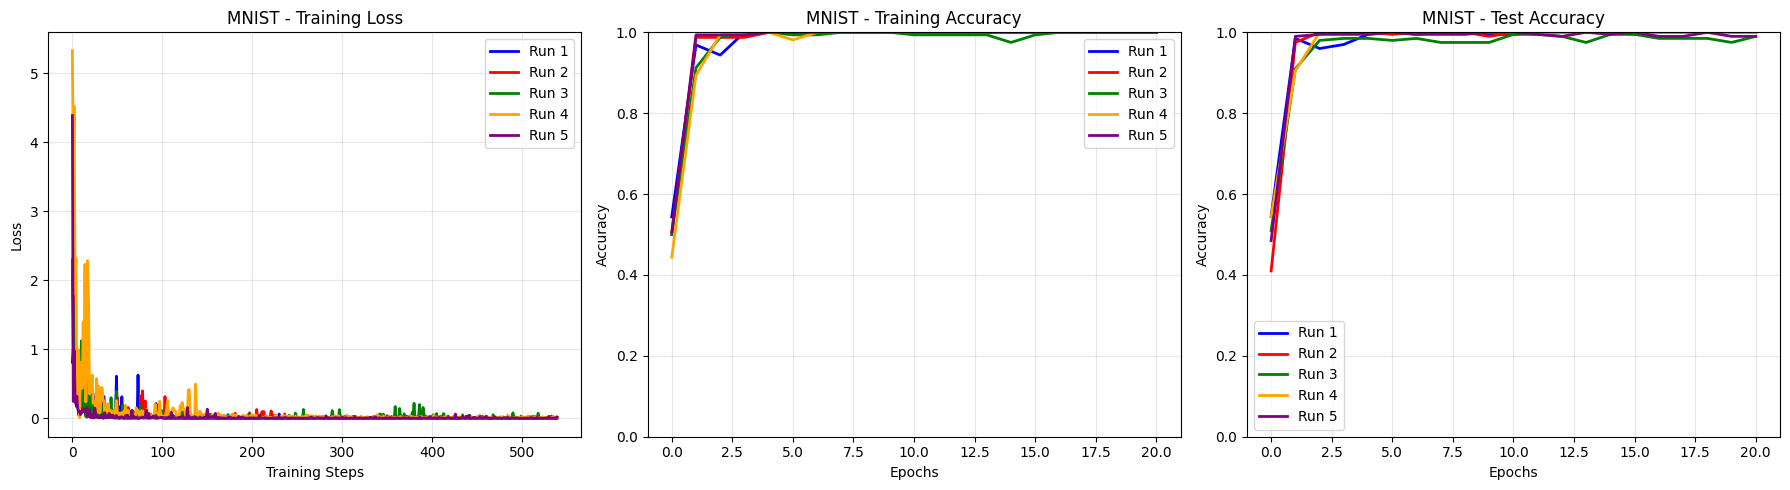


Summary Results:
Binary MNIST 0 vs 1:
  Train Accuracy: 1.000 ± 0.000
  Test Accuracy:  0.996 ± 0.005


In [21]:
# Save summary statistics
summary = {}
num_runs = len(all_results)
train_accs = [all_results[f"run_{i}"]["final_train_acc"] for i in range(num_runs)]
test_accs = [all_results[f"run_{i}"]["final_test_acc"] for i in range(num_runs)]

summary = {
    "train_acc_mean": np.mean(train_accs),
    "train_acc_std": np.std(train_accs),
    "test_acc_mean": np.mean(test_accs),
    "test_acc_std": np.std(test_accs),
    "train_accs": train_accs,
    "test_accs": test_accs,
}

# Create training plots for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ["blue", "red", "green", "orange", "purple"]

# Plot loss history for this dataset
ax_loss = axes[0]
for run_idx in range(num_runs):
    loss_history = all_results[f"run_{run_idx}"]["loss_history"]
    ax_loss.plot(
        loss_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_loss.set_title("MNIST - Training Loss")
ax_loss.set_xlabel("Training Steps")
ax_loss.set_ylabel("Loss")
ax_loss.legend()
ax_loss.grid(True, alpha=0.3)

# Plot train accuracy for this dataset
ax_train = axes[1]
for run_idx in range(num_runs):
    train_acc_history = all_results[f"run_{run_idx}"]["train_acc_history"]
    epochs = range(len(train_acc_history))
    ax_train.plot(
        epochs,
        train_acc_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_train.set_title("MNIST - Training Accuracy")
ax_train.set_xlabel("Epochs")
ax_train.set_ylabel("Accuracy")
ax_train.legend()
ax_train.grid(True, alpha=0.3)
ax_train.set_ylim(0, 1)

# Plot test accuracy for this dataset
ax_test = axes[2]
for run_idx in range(num_runs):
    test_acc_history = all_results[f"run_{run_idx}"]["test_acc_history"]
    epochs = range(len(test_acc_history))
    ax_test.plot(
        epochs,
        test_acc_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_test.set_title("MNIST - Test Accuracy")
ax_test.set_xlabel("Epochs")
ax_test.set_ylabel("Accuracy")
ax_test.legend()
ax_test.grid(True, alpha=0.3)
ax_test.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary Results:")
print("=" * 50)
print("Binary MNIST 0 vs 1:")
print(
    f"  Train Accuracy: {summary['train_acc_mean']:.3f} ± {summary['train_acc_std']:.3f}"
)
print(
    f"  Test Accuracy:  {summary['test_acc_mean']:.3f} ± {summary['test_acc_std']:.3f}"
)

As we can see, our PQCNN easily and consistently manages to classify 8x8 MNIST images between labels 0 and 1.

# 5. Classical comparison

Let us now compare these results with the ones from a classical CNN of comparable number of parameters. We first need to define this CNN:

In [23]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer: in_channels=1 (grayscale), out_channels=1, kernel=3
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3)  # 1*2*3*3 + 2 bias = 20 params
        # output of size (6, 6, 2)

        self.pool = nn.MaxPool2d(2, 2)
        # output of size (3, 3, 2)

        # Fully connected: after conv + pool, output size is 2 × 3 × 3 = 18
        self.fc1 = nn.Linear(18, 2)  # 18*2 + 2 biases = 38 params → we'll adjust

        # Total number of params: 58

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten except batch dim
        x = self.fc1(x)
        return x

Let us redefine the training function:

In [41]:
def train_model(model, train_loader, x_train, x_test, y_train, y_test):
    """Train a single model and return training history"""
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.1, weight_decay=0.001, betas=(0.7, 0.9)
    )
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    loss_fn = nn.CrossEntropyLoss()

    loss_history = []
    train_acc_history = []
    test_acc_history = []

    # Initial accuracy
    with torch.no_grad():
        output_train = model(x_train)
        pred_train = torch.argmax(output_train, dim=1)
        train_acc = (pred_train == y_train).float().mean().item()

        output_test = model(x_test)
        pred_test = torch.argmax(output_test, dim=1)
        test_acc = (pred_test == y_test).float().mean().item()

        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

    # Training loop
    for _epoch in trange(100, desc="Training epochs"):
        for _batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

        # Evaluate accuracy
        with torch.no_grad():
            output_train = model(x_train)
            pred_train = torch.argmax(output_train, dim=1)
            train_acc = (pred_train == y_train).float().mean().item()

            output_test = model(x_test)
            pred_test = torch.argmax(output_test, dim=1)
            test_acc = (pred_test == y_test).float().mean().item()

            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
        # scheduler.step()
    return {
        "loss_history": loss_history,
        "train_acc_history": train_acc_history,
        "test_acc_history": test_acc_history,
        "final_train_acc": train_acc,
        "final_test_acc": test_acc,
    }

Then we run the experiments:

In [42]:
all_results = {}

for i, random_state in enumerate(random_states):
    print(f"About to start experiment {i + 1}/5")
    x_train, x_test, y_train, y_test = get_mnist(random_state=random_state)
    x_train, x_test, y_train, y_test = convert_dataset_to_tensor(
        x_train, x_test, y_train, y_test
    )
    x_train = x_train.unsqueeze(dim=1)
    x_test = x_test.unsqueeze(dim=1)
    train_loader = convert_tensor_to_loader(x_train, y_train)
    dims = (8, 8)

    classical_cnn = SmallCNN()
    num_params = sum(p.numel() for p in classical_cnn.parameters() if p.requires_grad)
    print(f"Model has {num_params} trainable parameters")

    results = train_model(classical_cnn, train_loader, x_train, x_test, y_train, y_test)
    print(
        f"MNIST - Final train: {results['final_train_acc']:.4f}, test: {results['final_test_acc']:.4f}"
    )
    print(f"Experiment {i + 1}/5 completed")
    all_results[f"run_{i}"] = results

About to start experiment 1/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 155.31it/s]


MNIST - Final train: 0.9937, test: 1.0000
Experiment 1/5 completed
About to start experiment 2/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 145.70it/s]


MNIST - Final train: 1.0000, test: 0.9750
Experiment 2/5 completed
About to start experiment 3/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 156.62it/s]


MNIST - Final train: 1.0000, test: 0.9900
Experiment 3/5 completed
About to start experiment 4/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 161.77it/s]


MNIST - Final train: 0.9937, test: 0.9750
Experiment 4/5 completed
About to start experiment 5/5
Model has 58 trainable parameters


Training epochs: 100%|██████████| 100/100 [00:00<00:00, 162.42it/s]

MNIST - Final train: 1.0000, test: 0.9950
Experiment 5/5 completed


Visualize the results

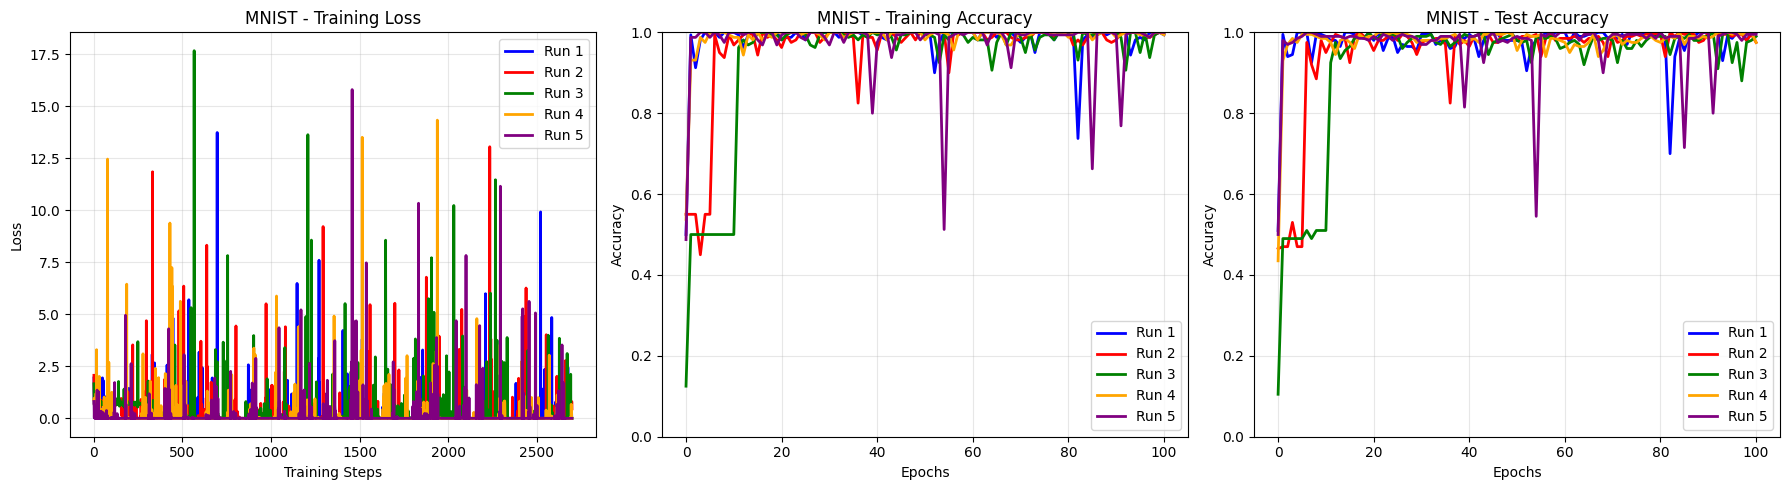


Summary Results:
Binary MNIST 0 vs 1:
  Train Accuracy: 0.997 ± 0.003
  Test Accuracy:  0.987 ± 0.010


In [43]:
# Save summary statistics
summary = {}
num_runs = len(all_results)
train_accs = [all_results[f"run_{i}"]["final_train_acc"] for i in range(num_runs)]
test_accs = [all_results[f"run_{i}"]["final_test_acc"] for i in range(num_runs)]

summary = {
    "train_acc_mean": np.mean(train_accs),
    "train_acc_std": np.std(train_accs),
    "test_acc_mean": np.mean(test_accs),
    "test_acc_std": np.std(test_accs),
    "train_accs": train_accs,
    "test_accs": test_accs,
}

# Create training plots for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ["blue", "red", "green", "orange", "purple"]

# Plot loss history for this dataset
ax_loss = axes[0]
for run_idx in range(num_runs):
    loss_history = all_results[f"run_{run_idx}"]["loss_history"]
    ax_loss.plot(
        loss_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_loss.set_title("MNIST - Training Loss")
ax_loss.set_xlabel("Training Steps")
ax_loss.set_ylabel("Loss")
ax_loss.legend()
ax_loss.grid(True, alpha=0.3)

# Plot train accuracy for this dataset
ax_train = axes[1]
for run_idx in range(num_runs):
    train_acc_history = all_results[f"run_{run_idx}"]["train_acc_history"]
    epochs = range(len(train_acc_history))
    ax_train.plot(
        epochs,
        train_acc_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_train.set_title("MNIST - Training Accuracy")
ax_train.set_xlabel("Epochs")
ax_train.set_ylabel("Accuracy")
ax_train.legend()
ax_train.grid(True, alpha=0.3)
ax_train.set_ylim(0, 1)

# Plot test accuracy for this dataset
ax_test = axes[2]
for run_idx in range(num_runs):
    test_acc_history = all_results[f"run_{run_idx}"]["test_acc_history"]
    epochs = range(len(test_acc_history))
    ax_test.plot(
        epochs,
        test_acc_history,
        color=colors[run_idx],
        alpha=1,
        linewidth=2,
        label=f"Run {run_idx + 1}",
    )
ax_test.set_title("MNIST - Test Accuracy")
ax_test.set_xlabel("Epochs")
ax_test.set_ylabel("Accuracy")
ax_test.legend()
ax_test.grid(True, alpha=0.3)
ax_test.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary Results:")
print("=" * 50)
print("Binary MNIST 0 vs 1:")
print(
    f"  Train Accuracy: {summary['train_acc_mean']:.3f} ± {summary['train_acc_std']:.3f}"
)
print(
    f"  Test Accuracy:  {summary['test_acc_mean']:.3f} ± {summary['test_acc_std']:.3f}"
)

With 58 parameters classically (versus the 60 quantum parameters), we end up with an equivalent performance in terms of accuracy. The non-smoothness of the classical training differentiates the two but more hyperparameters optimization could solve this issue.